# Forward Rendering

This notebook demonstrates how to solve the Polarized Radiative Transfer using SHDOM and render an image.

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [2]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np

import shdom

'\nImports necessary for this notebook\n'

In [5]:
""" 
Mie object loads a previously saved mie table.

Rayleigh object initilizes Rayleigh scattering according to a temperature profile.
Temperature profile here is of summer mid-latitude for 0-20km taken from AFGL.

Load a Large-Eddy-Simulated cloud from a csv file using a utility function: shdom.load_les_from_csv(path).
Using the loaded mie tables the liquid water content and effective radii will be transformed 
into the extinction and phase-function on a 3D grid (next cell). 
"""

# Mie scattering for water droplets
mie = shdom.MiePolarized()
mie.read_table(file_path='../mie_tables/Water_800nm_pol.scat')

' \nMie object loads a previously saved mie table.\n\nRayleigh object initilizes Rayleigh scattering according to a temperature profile.\nTemperature profile here is of summer mid-latitude for 0-20km taken from AFGL.\n\nLoad a Large-Eddy-Simulated cloud from a csv file using a utility function: shdom.load_les_from_csv(path).\nUsing the loaded mie tables the liquid water content and effective radii will be transformed \ninto the extinction and phase-function on a 3D grid (next cell). \n'

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.


In [7]:
phase_type = 'Tabulated'

atmosphere = shdom.Medium()

extinction, albedo, phase = mie.interpolate_scattering_field(microphysics.lwc, microphysics.reff, phase_type)
atmosphere.set_optical_properties(extinction, albedo, phase)

In [5]:
"""
Initilize an RteSolver object and attach the Medium to it. 
This will initialize all of shdom internal structures and grids.

SceneParameters() contains parameters such as surface albedo and solar radiance
NumericalParameters() contains parameters such as number of angular bins and split cell ratio.
All parameters have default values which can be viewed using print(params.info).
"""
numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=shdom.SolarSource(azimuth=180, zenith=130)
) 
rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.init_medium(atmosphere)

print(rte_solver.info)

Scene Parameters: 
   Wavelength: [0.672 micron]
   Surface: [Lambertian, albedo: 0.05]
   Source: [Solar, flux: 1.0, azimuth: 65deg, zenith: 135deg]
   Boundary Conditions: [x:open, y:open]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 10
   deltam: True
   cell_to_point_ratio: 1.5
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 100000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.003
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 9



In [6]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solver.solve(maxiter=100)

In [7]:
"""
Define a sensor and render an image of the domain. The Orthographic sensor is essentially
parallel rays measuring radiance at a given direction.
"""
sensor = shdom.OrthographicMonochromeSensor(
    wavelength=scene_params.wavelength,
    bounding_box=cloud.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)

image = sensor.render(rte_solver)

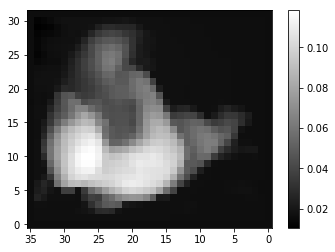

In [8]:
"""
Plot the synthetic image. 
axis are inverted so that image up would be pointing north and 
image left would be pointing East.
"""
%matplotlib inline
plt.imshow(image)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 
plt.gray()
plt.colorbar()

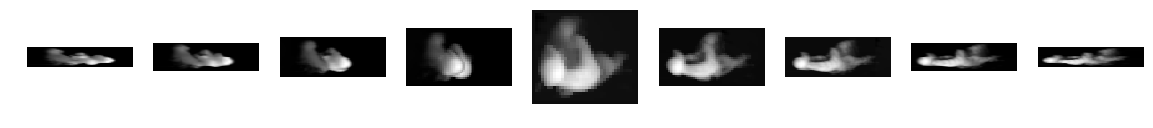

In [9]:
"""
Define a sensor array and render an multi-view images of the domain. 
Rendering can be done with the render() and par_render() methods.
Note that in some cases of small atmospheric domain, parallel rendering is slower due to comunication overhead.

Plot the synthetic images.
"""

# A fly over from East to West (negative y-axis direction)
zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
azimuth_list = [90, 90, 90, 90, 0, -90, -90, -90, -90]

sensors = shdom.SensorArray()

for zenith, azimuth in zip(zenith_list, azimuth_list):
    sensor = shdom.OrthographicMonochromeSensor(
        wavelength=scene_params.wavelength,
        bounding_box=cloud.bounding_box,
        x_resolution=0.02, 
        y_resolution=0.02, 
        azimuth=azimuth, 
        zenith=zenith,
        altitude='TOA'
    )
    sensors.add_sensor(sensor)

images = sensors.par_render(rte_solver, n_jobs=15)

%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 15))
for ax, image in zip(axarr, images):
    ax.imshow(image)
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off')
plt.gray()

## Save measurements and scene for optimization
---



In [10]:
"""
Define a Measurements object which contains the sensor geometry and the radiances.
The measurements object as an add_noise method which is useful to model sensor noise.

Save the forward model for inverse analysis.
"""

measurements = shdom.Measurements(sensors, images=images)
shdom.save_forward_model(
    directory='../experiments/jpl_les_32x36x25',
    medium=atmosphere,
    solver=rte_solver,
    measurements=measurements
)